#**Twitter Sentiment Analysis**

###Environment & API Setup

In [ ]:
!pip install kaggle
import os
import json
from google.colab import files

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

with zipfile.ZipFile("sentiment140.zip", "r") as zip_ref:
    zip_ref.extractall("twitter_data")

!ls twitter_data

training.1600000.processed.noemoticon.csv


###Import Libraries & Install Dependencies

In [ ]:
import re
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud

###Data Loading

In [ ]:
df = pd.read_csv("twitter_data/training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


###Data Cleaning & Preprocessing

In [ ]:
# Assign column names based on dataset description
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Convert sentiment to binary (0 = negative, 1 = positive)
df['sentiment'] = df['target'].apply(lambda x: 0 if x == 0 else 1)

# Sample 10,000 rows for performance
df_sample = df.sample(n=10000, random_state=42).copy()


In [ ]:
df_sample["sentiment"].value_counts()

,count
sentiment,
0,5004
1,4996


In [ ]:
df_sample.isnull().sum()

,0
target,0
ids,0
date,0
flag,0
user,0
text,0
sentiment,0


In [ ]:
# Download NLTK resources if not already done
nltk.download('stopwords')

# Initialize stemmer and stopwords
port_stem = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # 1. Remove URLs, mentions, hashtags, punctuation
    text = re.sub(r"http\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)

    # 2. Lowercase
    text = text.lower()

    # 3. Tokenize
    tokens = text.split()

    # 4. Remove stopwords and apply stemming
    stemmed = [port_stem.stem(word) for word in tokens if word not in stop_words]

    # 5. Return joined string
    return " ".join(stemmed)

df_sample['clean_text'] = df_sample['text'].apply(clean_text)
df_sample.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,target,ids,date,flag,user,text,sentiment,clean_text
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!,0,ahhh hope ok
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo...",0,cool tweet app razr 2
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...,0,know famili drama lamehey next time u hang kim...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...,0,school email wont open geographi stuff revis s...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem,0,upper airway problem


###Word Cloud Visualization

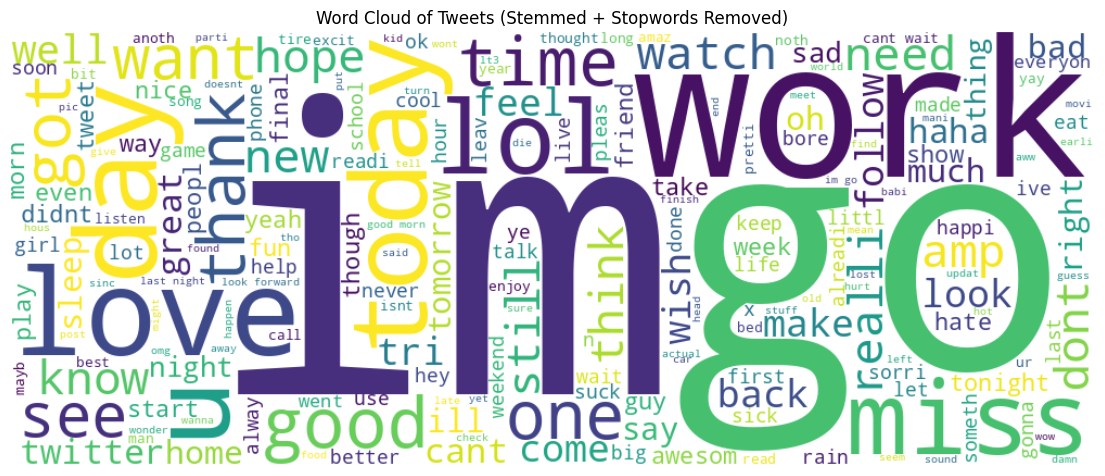

In [ ]:
# Combine all cleaned tweet text into one string
text_data = " ".join(df_sample['clean_text'])

# Generate the word cloud
wordcloud = WordCloud(width=1000, height=400, background_color='white').generate(text_data)

# Display the word cloud
plt.figure(figsize=(14, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Tweets (Stemmed + Stopwords Removed)")
plt.show()

###Train-Test Split

In [ ]:
X = df_sample['clean_text']
y = df_sample['sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###Feature Extraction: TF-IDF Vectorization

In [ ]:
# Converting textual data to numerical data
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

print(X_train.shape, X_test.shape)

(8000, 1000) (2000, 1000)


###Model Building and Comparison

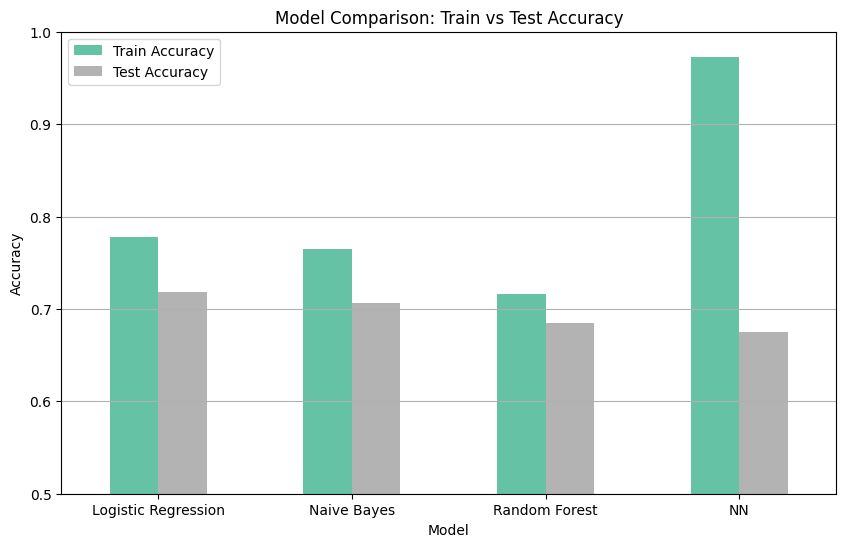

,Model,Train Accuracy,Test Accuracy
0,Logistic Regression,0.778000,0.7180
1,Naive Bayes,0.764375,0.7060
2,Random Forest,0.716125,0.6845
3,NN,0.972500,0.6755


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10,min_samples_split=10,
                                            min_samples_leaf=5,random_state=42),
    "NN": MLPClassifier(hidden_layer_sizes=(64,32), max_iter=1000, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    results.append({
        "Model": name,
        "Train Accuracy": accuracy_score(y_train, y_pred_train),
        "Test Accuracy": accuracy_score(y_test, y_pred_test)
    })

results_df = pd.DataFrame(results)


# PLOT ACCURACY
results_df.set_index('Model')[['Train Accuracy', 'Test Accuracy']].plot(kind='bar', figsize=(10,6), colormap='Set2')
plt.title("Model Comparison: Train vs Test Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.show()

# Display the results_df
results_df

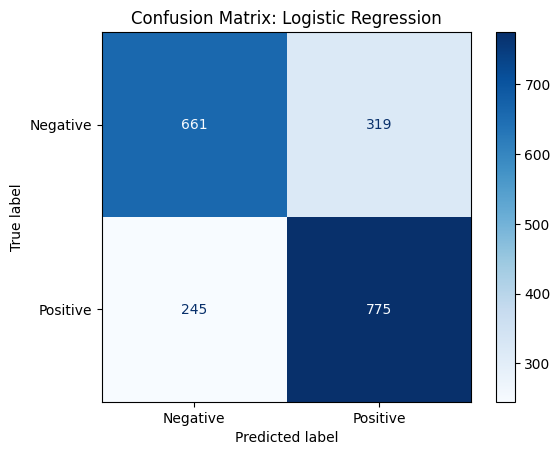

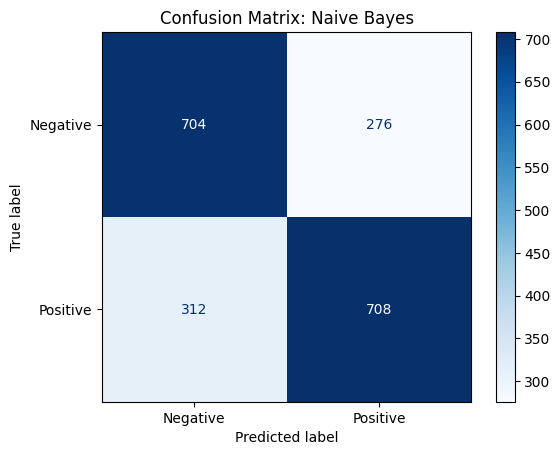

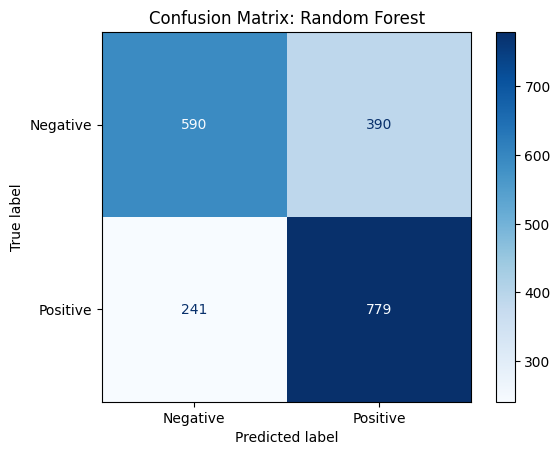

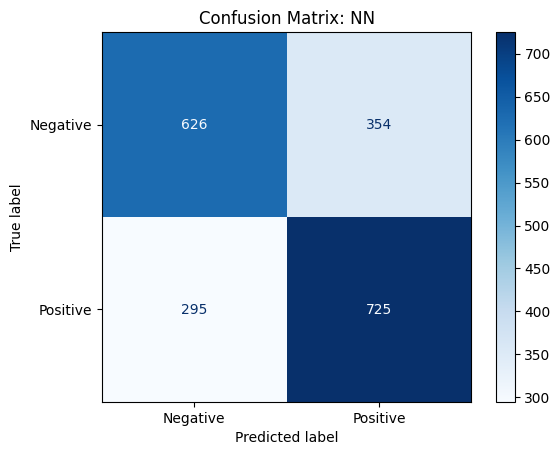

In [ ]:
# MODEL COMPARISON WITH DETAILED METRICS & CONFUSION MATRICES

metrics = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    prec = precision_score(y_test, y_pred_test)
    rec = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)

    # Get predicted probabilities for ROC AUC
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)[:, 1]
    else:  # For models without predict_proba (e.g., some SVMs)
        y_probs = model.decision_function(X_test)

    roc_auc = roc_auc_score(y_test, y_probs)

    # Append performance metrics
    metrics.append({
        "Model": name,
        "Train Accuracy": acc_train,
        "Test Accuracy": acc_test,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    })

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.grid(False)
    plt.show()


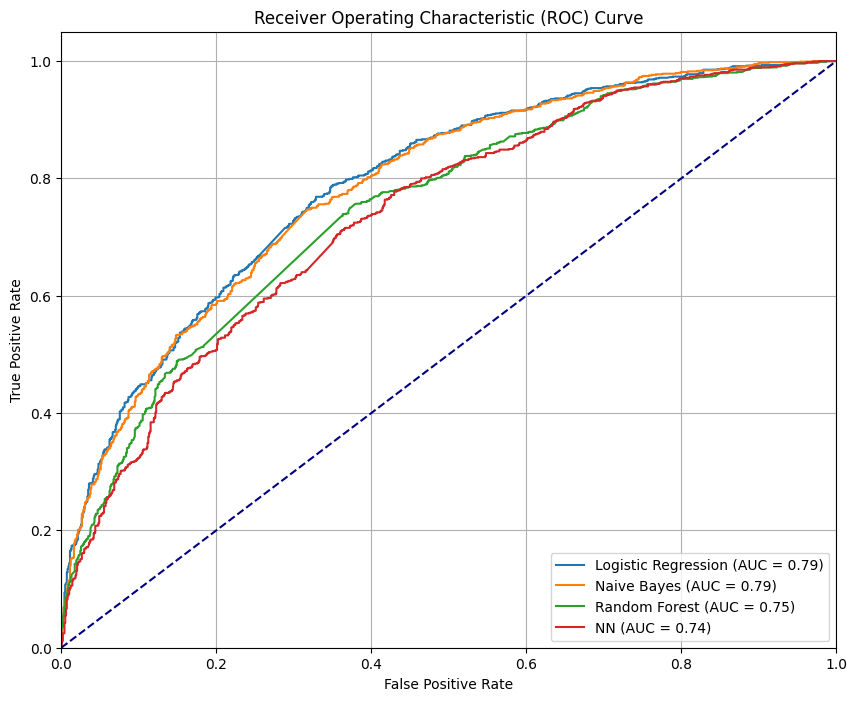

In [ ]:
# ROC - AUC Curve

plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Get predicted probabilities for the positive class
    y_probs = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve points
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)

    # Calculate AUC (Area Under Curve)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


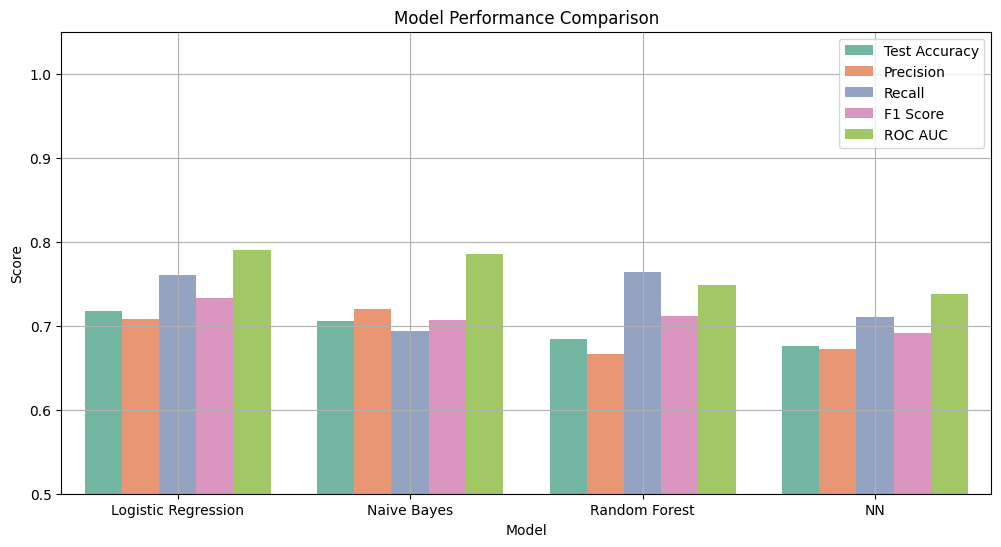

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.778,0.718,0.708,0.760,0.733,0.790
1,Naive Bayes,0.764,0.706,0.720,0.694,0.707,0.786
2,Random Forest,0.716,0.684,0.666,0.764,0.712,0.749
3,NN,0.972,0.676,0.672,0.711,0.691,0.738


In [ ]:
# Convert to DataFrame
metrics_df = pd.DataFrame(metrics)

# VISUAL COMPARISON OF ALL METRICS
melted = metrics_df.melt(
    id_vars="Model",
    value_vars=["Test Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"],
    var_name="Metric",
    value_name="Score"
)

plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x="Model", y="Score", hue="Metric", palette="Set2")
plt.title("Model Performance Comparison")
plt.ylim(0.5, 1.05)
plt.grid(True)
plt.ylabel("Score")
plt.legend(loc='upper right')
plt.show()

# Display full metrics table
metrics_df.round(3)


###Word Importance Analysis

/tmp/ipython-input-414466719.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words, x='Importance', y='Word', palette='coolwarm')


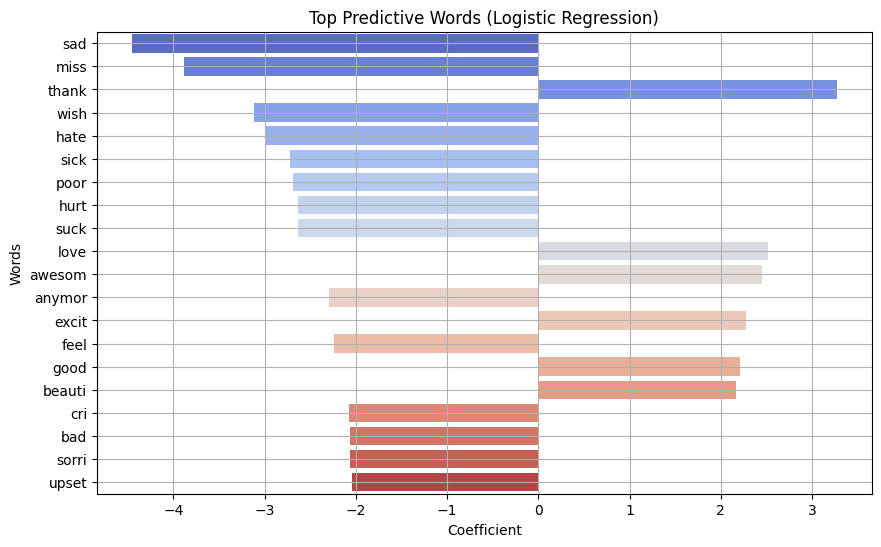

In [ ]:
# WORD IMPORTANCE (Logistic Regression)
log_model = LogisticRegression(max_iter=200)
log_model.fit(X_train, y_train)

feature_names = vectorizer.get_feature_names_out()
coefficients = log_model.coef_[0]
coef_df = pd.DataFrame({'Word': feature_names, 'Importance': coefficients})
coef_df['Abs'] = coef_df['Importance'].abs()
top_words = coef_df.sort_values(by='Abs', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(data=top_words, x='Importance', y='Word', palette='coolwarm')
plt.title("Top Predictive Words (Logistic Regression)")
plt.xlabel("Coefficient")
plt.ylabel("Words")
plt.grid(True)
plt.show()